---
# Importing Libraries
---

In [162]:
# Utility Libraries
import numpy as np
import pandas as pd
import sys
import time
import random
from scipy import linalg
import cv2
import string
from PIL import Image, ImageDraw
from PIL.Image import fromarray
import os
import re

# Pytorch relevant libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cat
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torchvision.models import inception_v3
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import random_split

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE

---
# Passage Indentification
---

In [4]:
def load_image_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [5]:
def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h * w_max / w) == 0 else int(h * w_max / w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255 * (img / 255.) ** gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [6]:
def load_image(image_path, w_max, gamma, hardcoded_range):
    img = load_image_from_path(image_path)
    hd1, hd2 = hardcoded_range
    hardcoded_img = img[hd1:hd2]
    img, (w, h), (wf, hf) = preprocess(img, w_max, gamma)
    hardcoded_img, (_, _), (_, _) = preprocess(hardcoded_img, w_max, gamma)
    wr, hr = wf / w, hf / h
    return img, hardcoded_img, (wf, hf), (wr, hr)

In [7]:
def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img

In [8]:
def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img

In [9]:
def generate_para(img, threshold, kernel_dims):
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    para_list = []
    para_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        para_list.append([x, y, w, h])
        para_images.append(img[y:y+h, x:x+w])
        break
        
    return para_images[0], para_list[0]

In [10]:
def get_img_and_vars(image_path, w_max, gamma, hardcoded_range, threshold, kernel_dims):
    img, himg, (wf, hf), (wr, hr) = load_image(image_path, w_max, gamma, hardcoded_range)
    para_img, (x,y,w,h) = generate_para(himg, threshold, kernel_dims)
    y = y + HARDCODED_RANGE[0]*hr
    y = int(y)
    return img, (x,y,w,h), (x/wf, y/hf, w/wf, h/hf)

In [11]:
image_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

In [12]:
def return_tensor(image):
    image = fromarray(image)
    return image_transform(image)

In [13]:
GAMMA = 2
W_MAX = 1000
THRESHOLD = 40
KERNEL_DIMS = (85, 85)
HARDCODED_RANGE = (710, 2800)

In [14]:
image_path = '/kaggle/input/iam-handwritten-forms-dataset/data/000/a01-000u.png'

---
### Removing non-handwritten parts of the image
---

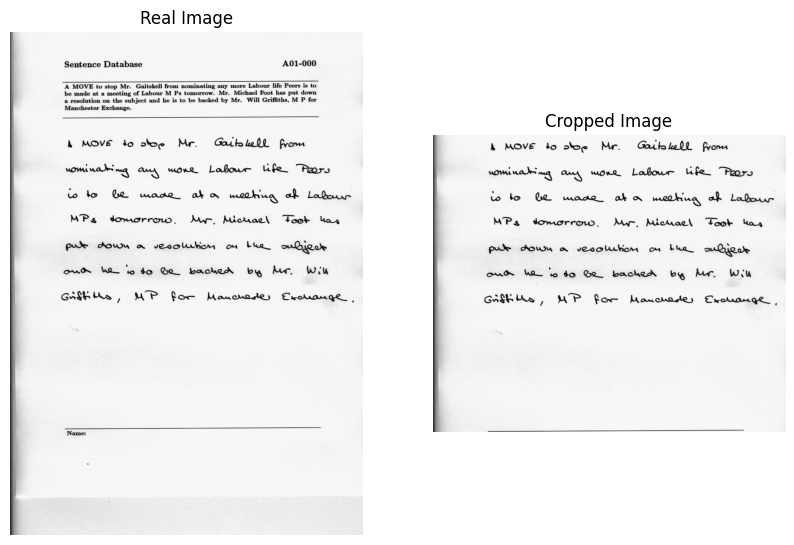

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
img, himg, (wf, hf), (wr, hr) = load_image(image_path, W_MAX, GAMMA, HARDCODED_RANGE)
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Real Image')
ax[1].imshow(himg)
ax[1].set_title('Cropped Image')
ax[1].axis('off')
plt.show()

---
### Get the (x, y, w, h) in terms of percentage wrt the entire page
---

x : 104, y : 286, w : 896, h : 527


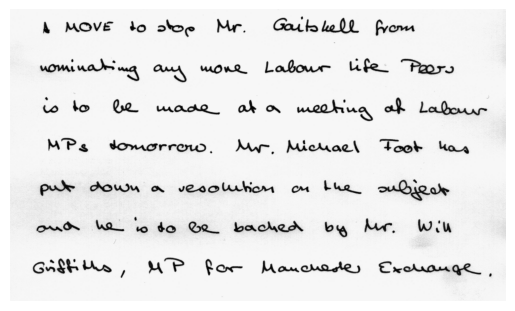

In [16]:
para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
plt.imshow(para_img)
plt.axis('off')
y = y + HARDCODED_RANGE[0] * hr
y = int(y)
print(f'x : {x}, y : {y}, w : {w}, h : {h}')
plt.show()

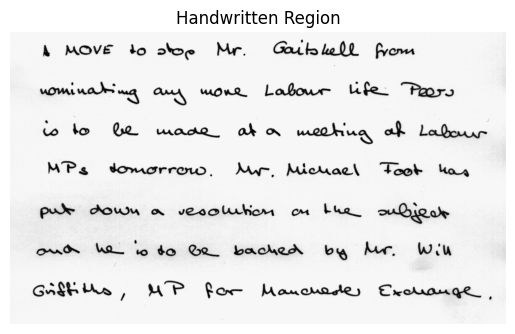

In [17]:
plt.imshow(img[y:y+h, x:x+w])
plt.title('Handwritten Region')
plt.axis('off')
plt.show()

In [18]:
# Saving (x, y, w, h) for bounding box of the dataset

"""
dataset_image_paths = []
dataset_labels_x = []
dataset_labels_y = []
dataset_labels_w = []
dataset_labels_h = []
maindir = '/kaggle/input/iam-handwritten-forms-dataset/data'
for subdir in os.listdir(maindir):
    subdir_path = os.path.join(maindir, subdir)
    for img_file in os.listdir(subdir_path):
        img_file_path = os.path.join(subdir_path, img_file)
        img, (_x,_y,_w,_h), (x,y,w,h) = get_img_and_vars(img_file_path, W_MAX, GAMMA, HARDCODED_RANGE, THRESHOLD, KERNEL_DIMS)
        if _w > 100 and _h > 100:
            dataset_image_paths.append(img_file_path)
            dataset_labels_x.append(x)
            dataset_labels_y.append(y)
            dataset_labels_w.append(w)
            dataset_labels_h.append(h)

df = pd.DataFrame({
    'image_path':dataset_image_paths,
    'x':dataset_labels_x,
    'y':dataset_labels_y,
    'w':dataset_labels_w,
    'h':dataset_labels_h
})
df.to_csv('paraseg.csv')
"""
pass

In [19]:
df = pd.read_csv('/kaggle/input/paraseg/paraseg.csv')

---
### Custom dataset for paragraph's bounding box
---

In [20]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.image_paths = df['image_path'].tolist()
        x = df['x'].tolist()
        y = df['y'].tolist()
        w = df['w'].tolist()
        h = df['h'].tolist()
        
        labels = np.array([x, y, w, h])
        self.labels = labels.T.tolist()

    def __len__(self):
        return df.shape[0]
    
    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx], self.labels[idx]
        img = load_image_from_path(img_path)
        img, _, _ = preprocess(img, W_MAX, GAMMA)
        img_tensor = return_tensor(img)
        return img_tensor, label

In [21]:
dataset = CustomDataset(df)
formdata_loader = DataLoader(dataset, batch_size=32, shuffle=True)

---
### Model to extract image features using ResNet34 and predict (x, y, w, h)
---

In [22]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()

        # Load pre-trained ResNet34 model
        self.resnet = models.resnet34(pretrained=True)

        # Modify the first convolutional layer to accommodate grayscale images
        conv1_weight = self.resnet.conv1.weight.data
        conv1_weight = conv1_weight.mean(dim=1, keepdim=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = conv1_weight

        # Remove the last fully connected layer of ResNet34
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Freeze the ResNet layers so they won't be trained
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Add fully connected layers
        self.fc1 = nn.Linear(512, 64)  # ResNet34 outputs 512 features
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)  # Output layer with 4 units for bounding box coordinates
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through ResNet layers
        x = self.resnet(x)

        # Flatten the output of ResNet
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)  # Applying sigmoid activation for bounding box coordinates

        return x

In [23]:
def train(model, criterion, optimizer, data_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = model.to(device)
    model.train()

    total_batches = len(data_loader)
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (img, target) in enumerate(data_loader):
            target = torch.stack(target, dim=1).float()
            img, target = img.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(img)

            # Separate the ground truth bounding box coordinates
            gt_x, gt_y, gt_w, gt_h = target[:, 0], target[:, 1], target[:, 2], target[:, 3]

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * img.size(0)
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item()}')

        epoch_loss /= len(data_loader.dataset)
        losses.append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss}')

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
model = ResNet34().to(device)

model.load_state_dict(torch.load('/kaggle/input/para-seg-model/model.pth'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s] 


<All keys matched successfully>

---
### Showing the predicted bounding box for paragraph
---

In [26]:
for images, _ in formdata_loader:
    images = images.to(device)
    y_hat = model(images)
    break

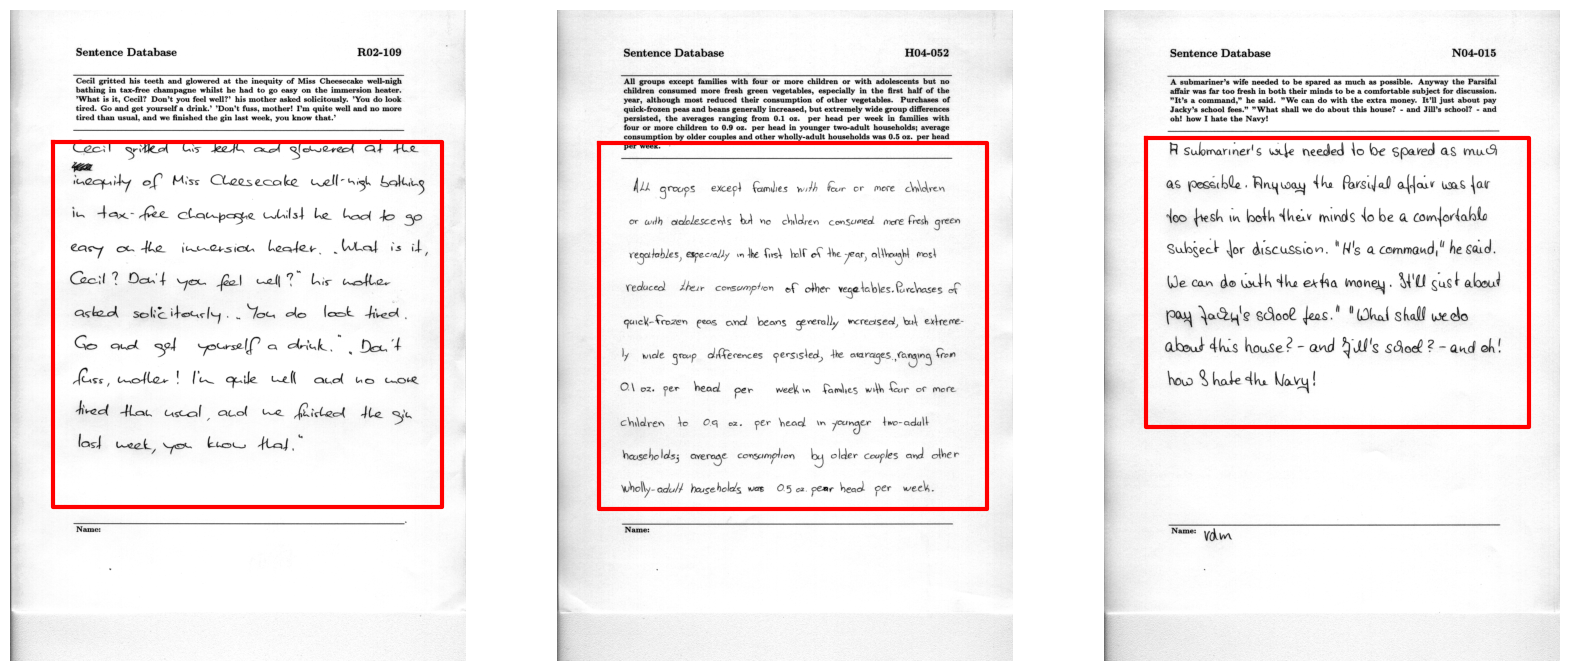

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 40))

for i in range(3):
    x, y, w, h = y_hat[i].detach()

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    w = w.cpu().numpy()
    h = h.cpu().numpy()

    image = images[i]

    height, width = image.shape[1], image.shape[2]

    x_left_top, y_left_top = x * width, y * height
    width, height = w * width, h * height

    x_right_top = x_left_top + width
    y_left_bottom = y_left_top + height
    ax[i].imshow(image.cpu().squeeze(), cmap='gray')
    ax[i].axis('off')
    ax[i].plot([x_left_top, x_left_top, x_right_top, x_right_top, x_left_top],
               [y_left_top, y_left_bottom, y_left_bottom, y_left_top, y_left_top],
               color='red', linewidth=3)

plt.show()

In [28]:
def get_cropped_image(image, model):
    img = image.unsqueeze(0).to(device)
    y_hat = model(img).squeeze()
    x, y, w, h = y_hat.detach().cpu().numpy()
    
    height, width = image.shape[1], image.shape[2]
    
    x_left_top, y_left_top = int(x * width), int(y * height)
    width, height = int(w * width), int(h * height)
    x_right_top = x_left_top + width
    y_left_bottom = y_left_top + height

    cropped_image = image[:, y_left_top:y_left_bottom, x_left_top:x_right_top]
    return cropped_image

In [29]:
def crop_images(images, y_hat):
    cropped_images = []

    for i in range(y_hat.shape[0]):  # Loop over each image in the batch
        x, y, w, h = y_hat[i].detach().cpu().numpy()  # Get bounding box coordinates for the ith image
        image = images[i].cpu().squeeze()  # Get the ith image from the batch

        height, width = image.shape[0], image.shape[1]

        x_left_top, y_left_top = int(x * width), int(y * height)
        width, height = int(w * width), int(h * height)
        x_right_top = x_left_top + width
        y_left_bottom = y_left_top + height

        # Get the cropped image
        cropped_image = image[y_left_top:y_left_bottom, x_left_top:x_right_top]

        cropped_images.append(cropped_image)

    # Resize each cropped image to the maximum width and height
    resize_transform = transforms.Resize((943, 890))

    resized_images = [resize_transform(torch.unsqueeze(img, 0)) for img in cropped_images]
    
    # Stack the resized images
    stacked_images = torch.stack(resized_images)
    
    return stacked_images

---
### Extracting the cropped images
---

In [30]:
# generating all cropped images

'''
cropped_images = []
for images, y_hat in data_loader:
    images = images.to(device)
    y_hat = model(images)
    cropped_images.extend(crop_images(images, y_hat))
    
torch.save(cropped_images, 'cropped_images.pt')
'''
pass

In [31]:
cropped_images = torch.load('/kaggle/input/iam-forms-cropped-images/cropped_images.pt')

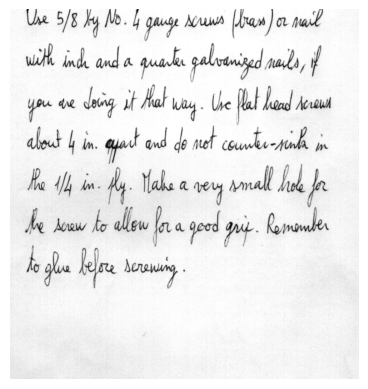

In [32]:
plt.imshow(cropped_images[0].permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

---
# Line Segmentation
---

---
### Generating Mask Images wrt Lines
---

In [33]:
def generate_lines_for_mask(img_tensor, w_max, gamma, threshold, kernel_dims,
                            num_lines_threshold=4, actual_size=False):
    img = tensor_to_cvarray(img_tensor)
    img, _, _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    lines_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            lines_images.append(img[y:y+h, x:x+w])
            
    if len(lines_images) <= num_lines_threshold:
        lines_images = []
    
    lines_tensor_list = []
    for each in lines_images:
        if actual_size:
            lines_tensor_list.append(convert_to_tensor(each))
        else:
            lines_tensor_list.append(convert_to_tensor(each, 900, 30))
    return lines_tensor_list

In [34]:
def generate_mask(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    num_lines = 0
    img = tensor_to_cvarray(img_tensor)
    img, (W,H), _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    mask = np.zeros(img.shape, np.uint8)

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            mask[y:y+h, x:x+w] = 255
            num_lines += 1
            
    return convert_to_tensor(img, 885, 903), convert_to_tensor(mask, 885, 903), (num_lines > num_lines_threshold)

In [35]:
LINE_KERNEL_DIMS = (20,800)

In [36]:
tensor_to_img_transform = transforms.ToPILImage()

In [37]:
def tensor_to_cvarray(img_tensor):
    img = tensor_to_img_transform(img_tensor)
    cv_img = np.array(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

In [38]:
def convert_to_tensor(image, w=None, h=None):
    image = fromarray(image)
    if w and h:
        image = transforms.Compose([transforms.Resize((h,w)), transforms.Grayscale(), transforms.ToTensor()])(image)
    else:
        image = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])(image)
    return image

In [39]:
def plot_tensor(img, axis='off'):
    plt.imshow(img.permute(1,2,0), cmap='gray')
    if axis == 'off':
        plt.axis('off')
    plt.show()

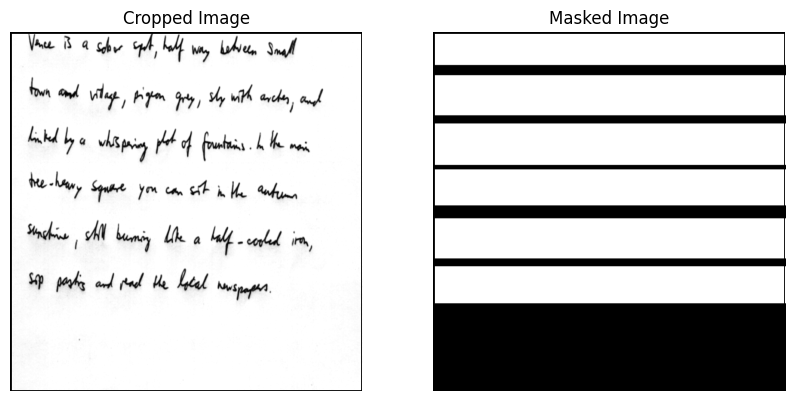

In [40]:
idx = 2
ll = generate_lines_for_mask(cropped_images[idx], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
im, ma, boolean = generate_mask(cropped_images[idx], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

# Display the first image with a border
ax[0].imshow(im.permute(1, 2, 0), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Cropped Image')
rect = patches.Rectangle((0, 0), im.size()[2], im.size()[1], linewidth=2, edgecolor='black', facecolor='none')
ax[0].add_patch(rect)

# Display the second image with a border
ax[1].imshow(ma.permute(1, 2, 0), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Masked Image')
rect = patches.Rectangle((0, 0), ma.size()[2], ma.size()[1], linewidth=2, edgecolor='black', facecolor='none')
ax[1].add_patch(rect)

plt.show()

In [41]:
class MaskDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return (self.images[idx], self.masks[idx])

In [42]:
# Generating Masked Dataset

"""
images_list = []
masks_list = []

for each in cropped_images:
    image, mask, boolean = generate_mask(each, W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
    if boolean:
        images_list.append(image)
        masks_list.append(mask)
        
dataset = MaskDataset(images_list, masks_list)
"""
pass

In [43]:
dataset = torch.load('/kaggle/input/iam-forms-masks/mask_dataset.pt')

In [44]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the dataset lengths
total_length = len(dataset)
train_length = int(train_ratio * total_length)
val_length = int(val_ratio * total_length)
test_length = total_length - train_length - val_length

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_length, val_length, test_length])

In [45]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

---
### UNet model for mask generation
---

In [46]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        return x

In [47]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvolutionBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        x = self.conv(x)
        output = self.pool(x)
        return x, output

In [48]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2,
            padding=0
        )

        self.conv = ConvolutionBlock(in_channels + out_channels, out_channels, dropout_rate)

    def forward(self, x, skip_connection):
        x = self.conv_transpose(x)
        x = torch.cat([x, skip_connection], axis=1)
        x = self.conv(x)

        return x

In [49]:
class UNet(nn.Module):
    def __init__(self, num_classes=2):
        super(UNet, self).__init__()
        
        self.enc1 = EncoderBlock(1, 16)
        self.enc2 = EncoderBlock(16, 32)
        self.enc3 = EncoderBlock(32, 64)
        
        self.dec1 = DecoderBlock(64, 32)
        self.dec2 = DecoderBlock(32, 16)
        self.dec3 = DecoderBlock(16, num_classes)
        
    def forward(self, x):
        skip_conn1, x = self.enc1(x)
        skip_conn2, x = self.enc2(x)
        skip_conn3, x = self.enc3(x)

        x = self.dec1(x, skip_conn3)
        x = self.dec2(x, skip_conn2)
        x = self.dec3(x, skip_conn1)
        
        return x

In [50]:
# Code to train the UNet

"""
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = F.interpolate(images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
        masks = F.interpolate(masks, size=(1024, 1024), mode='bilinear', align_corners=False)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.type(torch.LongTensor).to(device)

        optimizer.zero_grad()
        outputs = unet(images)
        softmax = F.softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        torch.cuda.empty_cache()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}', end=', ')

    unet.eval()
    val_loss = 0.0
    for val_images, val_masks in val_loader:
        val_images = F.interpolate(val_images, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
        val_masks = F.interpolate(val_masks, size=(1024, 1024), mode='bilinear', align_corners=False)
        val_masks = val_masks.reshape(val_masks.shape[0], val_masks.shape[2], val_masks.shape[3])
        val_masks = val_masks.type(torch.LongTensor).to(device)

        with torch.no_grad():
            val_outputs = unet(val_images)
            val_softmax = F.softmax(val_outputs, dim=1)
            val_loss += criterion(val_softmax, val_masks).item()
            
        torch.cuda.empty_cache()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')
    unet.train()
"""
pass

In [51]:
unet = UNet(num_classes=2).to(device)

In [52]:
unet = torch.load('/kaggle/input/line-segmentor-model/unet_cross_entropy.pth')

In [53]:
for images, _ in train_loader:
    images = F.interpolate(images, size=(1024, 1024), mode='bilinear', align_corners=False)
    break

---
### Predicted Masks
---

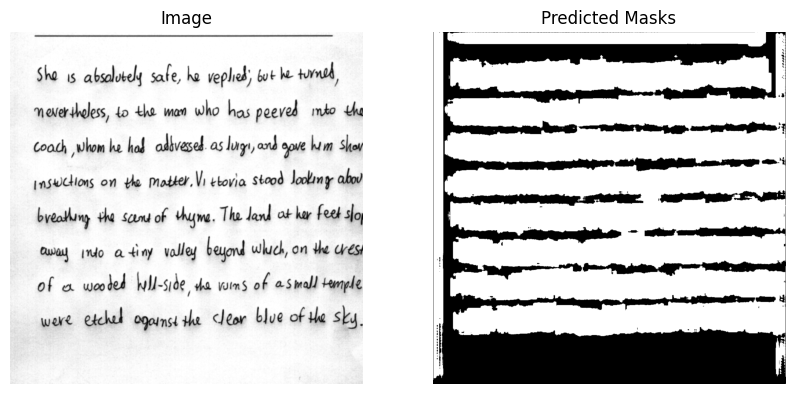

In [54]:
torch.cuda.empty_cache()
output = unet(images.to(device))
predicted_masks = output.argmax(dim=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(images[0].permute(1, 2, 0), cmap='gray')
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(predicted_masks.cpu().detach().permute(1, 2, 0), cmap='gray')
ax[1].set_title('Predicted Masks')
ax[1].axis('off')

plt.show()

---
### Extract lines from predicted text
---

In [55]:
def convert_to_cvimg(img_tensor):
    pil_img = transforms.ToPILImage()(img_tensor.to(float))
    cv_img = np.array(pil_img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

def generate_lines_from_mask(actual_img_tensor, mask_img_tensor, w_max, gamma, threshold, kernel_dims,
                             num_lines_threshold=4):
    actual_img = convert_to_cvimg(actual_img_tensor)
    mask_img = convert_to_cvimg(mask_img_tensor)
    
    img_gray = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((1,1), np.uint8)
    dilated_img = cv2.dilate(img_gray, kernel, iterations = 0)
    
    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    lines_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            lines_images.append(actual_img[y:y+h, x:x+w])
    
    lines_tensor_list = []
    for each in lines_images:
        lines_tensor_list.append(convert_to_tensor(each))
    lines_tensor_list = generate_lines_for_mask(actual_img_tensor, w_max, gamma, threshold, kernel_dims, actual_size=True)
    return lines_tensor_list

In [56]:
generated_lines = generate_lines_from_mask(images[0], predicted_masks[0], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)

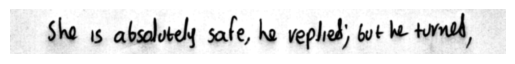

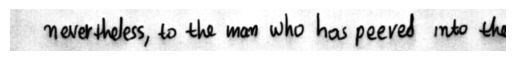

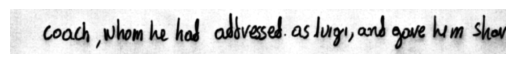

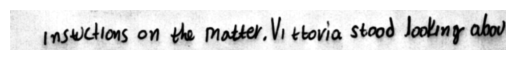

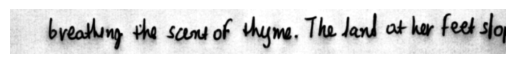

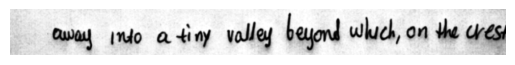

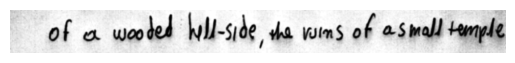

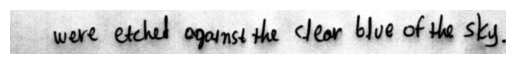

In [57]:
for each in generated_lines:
    plot_tensor(each)

---
# Line to Word Segmentation
---

In [58]:
WORD_KERNEL_DIMS = (12,12)

---
### Generating bounding box data for line images
---

In [59]:
def generate_line_images(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    img = tensor_to_cvarray(img_tensor)
    img, _, _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    lines_images = []

    wl = []
    hl = []
    
    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        if w >= 100 and h >= 20 and area>=10000:
            wl.append(w)
            hl.append(h)
            lines_images.append(img[y:y+h, x:x+w])
            
    if len(lines_images) <= num_lines_threshold:
        lines_images = []
    
    hmedian = median(hl)
    
    lines_tensor_list = []
    for each in range(len(lines_images)):
        himg = hl[each]
        if himg > 0.5*hmedian:
            if himg <+ 1.5*hmedian:
                lines_tensor_list.append(convert_to_tensor(lines_images[each]))
            else:
                limg1 = lines_images[each][:himg//2]
                limg2 = lines_images[each][himg//2:]
                lines_tensor_list.append(convert_to_tensor(limg1))
                lines_tensor_list.append(convert_to_tensor(limg2))
    
    return lines_tensor_list

In [60]:
def generate_word_images(img_tensor, threshold, kernel_dims):
    img = tensor_to_cvarray(img_tensor)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    words_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        words_images.append([img[y:y+h, x:x+w], x, y, w, h])
    
    words_images.sort(key=lambda x: x[1])

    words_tensor_list = []
    for each, x, y, w, h in words_images:
        words_tensor_list.append([convert_to_tensor(each), [x,y,w,h]])

    return words_tensor_list

In [61]:
def generate_lines_and_bboxes(img_tensor):
    lt = generate_line_images(img_tensor, THRESHOLD, LINE_KERNEL_DIMS)
    line_lists = []
    bb_list = []
    for lidx in range(len(lt)):
        words = generate_word_images(lt[lidx], THRESHOLD, WORD_KERNEL_DIMS)
        limg = tensor_to_cvarray(lt[lidx])
        linew, lineh, c = limg.shape
        bbox = []
        for each in words:
            x,y,w,h = each[1]
            x = math.ceil(x*1000/lineh)
            w = math.ceil(w*1000/lineh)
            y = math.ceil(y*80/linew)
            h = math.ceil(h*80/linew)
            bbox.append([x, y, x+w, y+h])
        
        line_lists.append(convert_to_tensor(limg, 1000, 80))
        bb_list.append(bbox)
    
    return line_lists, bb_list

In [62]:
# saving bounding box data

'''
ll_final = []
bb_final = []

total_images = len(cropped_images)

for each in range(total_images):
    print(f'generating bounding boxes for image {each+1}/{total_images}')
    ll, bb = generate_lines_and_bboxes(cropped_images[each])
    ll_final.extend(ll)
    bb_final.extend(bb)

torch.save(ll_final, 'line_images.pt')
torch.save(bb_final, 'line_bboxes.pt')
'''
pass

In [63]:
ll_final = torch.load('/kaggle/input/iam-line-images-and-bboxes/line_images.pt')
bb_final = torch.load('/kaggle/input/iam-line-images-and-bboxes/line_bboxes.pt')

In [64]:
class BBoxDataset(Dataset):
    def __init__(self, lines_list, bb_list):
        self.lines_list = lines_list
        self.bb_list = bb_list
    
    def __len__(self):
        return len(self.lines_list)
    
    def __getitem__(self, idx):
        img = self.lines_list[idx]
        boxes = self.bb_list[idx]
        labels = torch.ones((len(boxes)), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return img, target

In [65]:
db = BBoxDataset(ll_final[:100], bb_final[:100])
resu1t_bbox = bb_final[130]
dataloader = DataLoader(db, batch_size=32, collate_fn=lambda x:x, shuffle=True,
                        pin_memory=True if torch.cuda.is_available() else False)

In [66]:
# loading and fine tuning pre-trained faster rcnn model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

'''
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

for epochs in range(num_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    epoch_loss = 0
    for data in tqdm(dataloader):
        imgs = []
        targets = []
        for d in tqdm(data):
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]['boxes'].to(device)
            targ["labels"] = d[1]['label'].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)
'''
pass

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 159MB/s] 


In [67]:
# loading fine-tuned model
model.load_state_dict(torch.load('/kaggle/input/line-to-word-model/line_to_word_model.pth'))

<All keys matched successfully>

In [68]:
test_img = ll_final[130]
test_bbox = bb_final[130]
model.eval()
res = model([test_img])

In [69]:
result_bbox = res[0]['boxes']
result_scores = res[0]['scores']
test_img = tensor_to_cvarray(test_img)

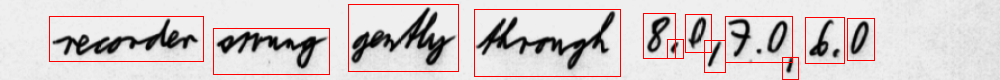

In [70]:
vsample = Image.fromarray(test_img)
draw = ImageDraw.Draw(vsample)
for box in resu1t_bbox:
    draw.rectangle(list(box), fill=None, outline='red')
vsample

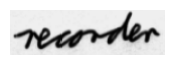

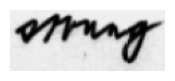

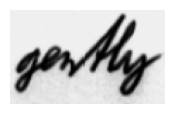

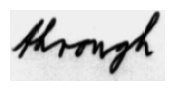

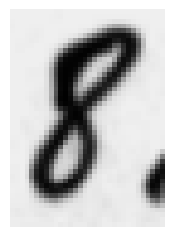

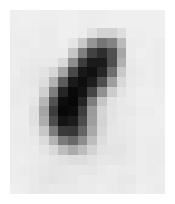

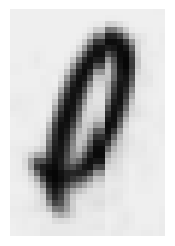

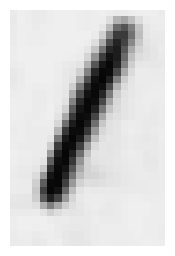

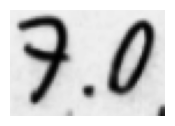

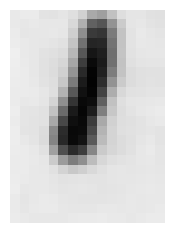

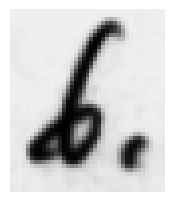

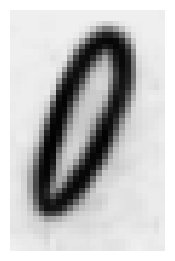

In [71]:
for box in resu1t_bbox:
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    plt.figure(figsize=(2, 8))
    plt.imshow(test_img[y1:y2, x1:x2])
    plt.axis('off')
    plt.show()

In [72]:
def generate_word_image_tensors(model, img_tensor, threshold, kernel_dims):
    model.eval()
    res = model([img_tensor])
    res_bbox = res[0]['boxes']
    res_scores = res[0]['scores']
    
    img = tensor_to_cvarray(img_tensor)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    words_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        words_images.append([img[y:y+h, x:x+w], x, y, w, h])
    
    words_images.sort(key=lambda x: x[1])

    words_tensor_list = []
    for each, x, y, w, h in words_images:
        words_tensor_list.append(convert_to_tensor(each, 128, 32))

    return words_tensor_list

---
# Word Recognizer
---

In [73]:
with open('/kaggle/input/iam-handwriting-word-database/iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents]

In [74]:
file_names = []
texts = []

for line in lines:
    file_name = line.split()[0]
    text = line.split()[-1]
    
    file_names.append(file_name)
    texts.append(text)

In [75]:
words_data = pd.DataFrame()
words_data['file_name'] = file_names
words_data['text'] = texts

In [76]:
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

def encode_to_labels(text, max_word_length=17):
    dig_list = []
    for index in range(max_word_length):
        char = 78
        if index < len(text):
            char = char_list.index(text[index])
        dig_list.append(char) 
        
    return dig_list

In [77]:
class IAMDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.data['file_name'][idx]
        text = self.data['text'][idx]

        # Construct file path
        part = file_name.split('-')
        file_name = file_name + '.png'
        file_path = f"{self.root_dir}/{part[0]}/{part[0]}-{part[1]}/{file_name}"

        # Load image
        try:
            image = Image.open(file_path).convert("RGB")
        except:
            image = torch.zeros((1, 32, 128))
            label = torch.zeros((17))
            return image, label


        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(encode_to_labels(text))

        return image, torch.tensor(label)

In [78]:
transform = transforms.Compose([
    transforms.Grayscale(),   
    transforms.Resize((32, 128)),
    transforms.ToTensor()
])

In [79]:
dataset = IAMDataset(data=words_data, root_dir='/kaggle/input/iam-handwriting-word-database/iam_words/words', transform=transform)

In [80]:
batch_size = 128

# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

---
### CNN + RNN + CTCLoss
---

In [81]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.batch_norm5(x)
        x = F.relu(self.conv6(x))
        x = self.batch_norm6(x)
        x = self.pool6(x)
        x = F.relu(self.conv7(x))
        x = x.squeeze(2)  # Squeeze the height dimension
        x = x.permute(2, 0, 1)  # Reshape for RNN input
        return x

In [82]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(1), self.hidden_size).to(device)
        output, _ = self.lstm(x, (h0, c0))
        output = self.fc(output)
        return output

In [83]:
class HandwritingRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(HandwritingRecognitionModel, self).__init__()
        self.cnn = CNN()
        self.rnn = RNN(input_size=512, hidden_size=256, num_layers=2, num_classes=num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.rnn(x)
        return x

In [84]:
# Code to optimize CTC Loss

"""
num_classes = 79  # 78 characters + 1 for blank
num_epochs = 300
model = HandwritingRecognitionModel(num_classes)

# Loss function
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
T = 31
C = 79
S = 17
S_min = 16

model = model.to(device)
for epoch in range(num_epochs):
    losses = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        N = images.shape[0]
        optimizer.zero_grad()
        outputs = model(images)
        input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
        target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
        loss = criterion(outputs, labels, input_lengths, target_lengths)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} : Loss : {np.round(np.mean(losses), 3)}")
"""
pass

In [85]:
num_classes = 79
model = HandwritingRecognitionModel(num_classes).to(device)

model.load_state_dict(torch.load('/kaggle/input/word-recognizer-model/dl_project_model.pth'))

<All keys matched successfully>

In [86]:
def get_text(sequence):
    text = ""
    for i in sequence:
        i = i.item()
        if i != 78:
            text += char_list[i]
    return text

In [241]:
def get_text_line(sequence):
    text = ""
    for i in sequence:
        i = i.item()
        if i != 79:
            text += char_list[i]
    return text

In [87]:
def ctc_greedy_decode_batch(logits, blank_index=0):
    """
    Greedy decoding for CTC output for a batch of sequences.
    
    Args:
    logits (np.array): Logits from the model, shape (T, batch_size, C),
                       where T is the sequence length, batch_size is the
                       batch size, and C is the number of characters.
    blank_index (int): Index of the blank symbol.
    
    Returns:
    decoded_sequences (list of lists): Decoded sequences of characters for each batch element.
    """
    T, batch_size, C = logits.shape
    decoded_sequences = []

    for b in range(batch_size):
        # Get the logits for the current batch element
        batch_logits = logits[:, b, :]
        
        # Get the index with maximum probability for each timestep
        best_path = np.argmax(batch_logits, axis=1)
        
        # Collapse consecutive duplicates and remove blank symbols
        decoded_sequence = [best_path[0]]
        for i in range(1, len(best_path)):
            if best_path[i] != blank_index and best_path[i] != best_path[i - 1]:
                decoded_sequence.append(best_path[i])
        
        decoded_sequences.append(decoded_sequence)

    output_text = []
    for sequence in decoded_sequences:
        output_text.append(get_text(sequence))
    
    return output_text

In [88]:
def show_prediction(image, actual_label, model=model):
    image = image.unsqueeze(0).to(device)
    model = model.to(device)
    output = model(image)
    predicted_text = ctc_greedy_decode_batch(output.detach().cpu())[0]
    
    image = image.reshape(32, 128, 1)
    plt.imshow(image.cpu(), cmap='gray')
    plt.axis('off')
    print(f"Actual : {get_text(actual_label)}", end=", ")
    print(f"Predicted : {predicted_text}")
    plt.show()

In [89]:
for images, labels in train_loader:
    break

/tmp/ipykernel_34/1827880354.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label)


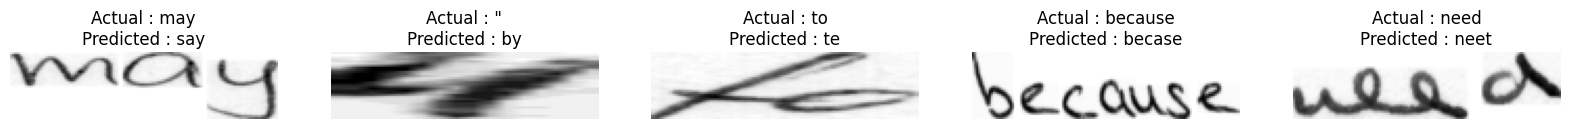

In [90]:
fig, ax = plt.subplots(1, 5, figsize=(20, 40))

for i in range(5):
    image = images[i]
    label = labels[i]
    
    image = image.unsqueeze(0).to(device)
    output = model(image)
    predicted_text = ctc_greedy_decode_batch(output.detach().cpu())[0]
    image = image.reshape(32, 128, 1)
    ax[i].imshow(image.cpu(), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Actual : {get_text(label)}\nPredicted : {predicted_text}')
plt.show()

---
# Spelling Corrector
---

In [108]:
class NoisyTextDataset(Dataset):
    def __init__(self, noisy_texts, original_texts):
        self.noisy_texts = noisy_texts
        self.original_texts = original_texts
        
        # Create vocabularies for input and output texts
        self.input_vocab = self.build_vocab(noisy_texts)
        self.output_vocab = self.build_vocab(original_texts)
        
        # Create dictionaries for encoding and decoding
        self.input_encoder = {char: idx for idx, char in enumerate(self.input_vocab)}
        self.output_encoder = {char: idx for idx, char in enumerate(self.output_vocab)}
        self.output_decoder = {idx: char for char, idx in self.output_encoder.items()}
        
        # Add start and end tokens to the output vocabulary
        self.output_vocab = ['<sos>'] + self.output_vocab + ['<eos>']
        self.output_encoder = {char: idx for idx, char in enumerate(self.output_vocab)}
        self.output_decoder = {idx: char for char, idx in self.output_encoder.items()}
    
    def build_vocab(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text)
        return sorted(list(vocab))
    
    def __len__(self):
        return len(self.noisy_texts)
    
    def __getitem__(self, idx):
        noisy_text = self.noisy_texts[idx]
        original_text = self.original_texts[idx]

        # Encode input text
        input_tensor = torch.tensor([self.input_encoder[char] for char in noisy_text], dtype=torch.long)

        # Encode output text with start and end tokens
        output_tensor = torch.tensor([self.output_encoder['<sos>']] +
                                     [self.output_encoder[char] for char in original_text] +
                                     [self.output_encoder['<eos>']], dtype=torch.long)

        return input_tensor, output_tensor

    @staticmethod
    def collate_fn(batch):
        noisy_texts, original_texts = zip(*batch)
        
        # Pad the input sequences
        noisy_texts = pad_sequence([seq for seq in noisy_texts], batch_first=True)
        
        # Pad the output sequences
        original_texts = pad_sequence([seq for seq in original_texts], batch_first=True)
        
        return noisy_texts, original_texts

In [114]:
dataset = torch.load('/kaggle/input/noise-correct-data/noise_correct_data.pt')

In [115]:
dataloader = DataLoader(dataset, batch_size=64, collate_fn=dataset.collate_fn, shuffle=True)

In [119]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, input_tensor):
        embedded = self.embedding(input_tensor)
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [120]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Create the output encoder and decoder
        self.output_vocab = ['<sos>'] + list(range(output_size)) + ['<eos>']
        self.output_encoder = {char: idx for idx, char in enumerate(self.output_vocab)}
        self.output_decoder = {idx: char for char, idx in self.output_encoder.items()}

    def forward(self, input_tensor, hidden, cell):
        embedded = self.embedding(input_tensor)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        output = self.fc(output[:, -1, :])
        return output, hidden, cell

In [121]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input_tensor, target_tensor):
        batch_size = input_tensor.size(0)
        max_length = target_tensor.size(1)

        hidden, cell = self.encoder(input_tensor)
        output_tensor = torch.tensor([[self.decoder.output_encoder['<sos>']] for _ in range(batch_size)], device=self.device)

        outputs = []
        for _ in range(max_length):
            output, hidden, cell = self.decoder(output_tensor, hidden, cell)
            outputs.append(output)
            output_tensor = output.argmax(dim=1).unsqueeze(1)

        output_tensor = torch.stack(outputs, dim=1)
        return output_tensor

In [122]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    start_time = time.time()
    loss_trajectory = []  # Store loss values for visualization
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0
        for noisy_texts, original_texts in train_loader:  # Changed from dataloader to train_loader
            noisy_texts = noisy_texts.to(device)
            original_texts = original_texts.to(device)

            # Forward pass
            output_tensor = model(noisy_texts, original_texts[:, :-1])
            loss = criterion(output_tensor.view(-1, output_tensor.size(-1)), original_texts[:, 1:].reshape(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            torch.cuda.empty_cache()
            
            num_batches += 1
            if num_batches % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch : {num_batches}, Loss : {loss.item()}, Time Elapsed: {int(time.time() - start_time)} s")

        epoch_loss = total_loss / len(train_loader)
        loss_trajectory.append(epoch_loss)  # Append epoch loss to loss trajectory
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return model, loss_trajectory

In [123]:
input_size = len(dataset.input_vocab)
output_size = len(dataset.output_vocab)
hidden_size = 128
num_layers = 2
dropout = 0.2

encoder = Encoder(input_size, hidden_size, num_layers, dropout).to(device)
decoder = Decoder(output_size, hidden_size, num_layers, dropout).to(device)
model = Seq2SeqModel(encoder, decoder).to(device)

In [120]:
# Code to train the Seq2Seq model

"""
criterion = nn.CrossEntropyLoss(ignore_index=dataset.output_encoder['<eos>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

trained_model, loss_trajectory = train_model(model, dataloader, criterion, optimizer, num_epochs, device)
"""
pass

In [124]:
model = torch.load('/kaggle/input/spelling-corrector/spelling_corrector.pth').to(device)

---
# Constructing the final pipeline
---

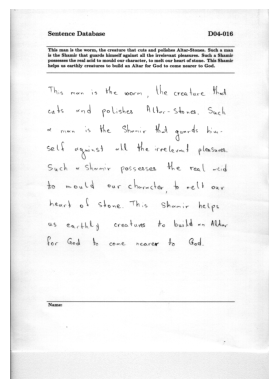

In [202]:
for images, labels in formdata_loader:
    images = images.to(device)
    plot_tensor(images[0].cpu().detach())
    break

In [203]:
# Step 1: Paragraph segmentation
paragraph_segmentor = ResNet34().to(device)
paragraph_segmentor.load_state_dict(torch.load('/kaggle/input/para-seg-model/model.pth'))

# Step 2: Line segmentation
line_segmentation = UNet(num_classes=2).to(device)
line_segmentation = torch.load('/kaggle/input/line-segmentor-model/unet_cross_entropy.pth')

# Step 3: Word segmentation
word_segmentation = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = word_segmentation.roi_heads.box_predictor.cls_score.in_features
word_segmentation.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
word_segmentation.load_state_dict(torch.load('/kaggle/input/line-to-word-model/line_to_word_model.pth'))

# Step 4: Word recognizer
word_recognizer = HandwritingRecognitionModel(num_classes=79).to(device)
word_recognizer.load_state_dict(torch.load('/kaggle/input/word-recognizer-model/dl_project_model.pth'))

# Step 5: Spell Checker
spelling_checker = torch.load('/kaggle/input/spelling-corrector/spelling_corrector.pth').to(device)

In [220]:
class IAMDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.data['file_name'][idx]
        text = self.data['text'][idx]

        file_name = file_name
        file_path = f"{self.root_dir}/{file_name}"

        # Load image
        try:
            image = Image.open(file_path).convert("RGB")
        except:
            image = torch.zeros((1, 30, 900))
            label = torch.zeros((85))
            return image, label


        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(encode_to_labels(text))

        return image, torch.tensor(label)

In [230]:
dataset = torch.load('/kaggle/input/lines-data/lines_data.pt')

In [235]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [256]:
def handwritting_to_text(image):
    cropped_image = get_cropped_image(image, paragraph_segmentor).unsqueeze(0)
    cropped_image = F.interpolate(cropped_image, size=(1024, 1024), mode='bilinear', align_corners=False).to(device)
    
    predicted_mask = line_segmentation(cropped_image).argmax(dim=1)
    generated_lines = generate_lines_from_mask(cropped_image[0], predicted_masks[0], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
    passage_text = []
    for line in generated_lines:
        words = generate_word_image_tensors(word_segmentation, line, THRESHOLD, WORD_KERNEL_DIMS)
        line_text = []
        for word in words:
            y_hat = word_recognizer(word.unsqueeze(0).to(device))
            predicted_text = ctc_greedy_decode_batch(y_hat.detach().cpu())[0]
            line_text.append(predicted_text)
        line_text = ' '.join(line_text)
        passage_text.append(line_text)
    passage_text = '\n'.join(passage_text)
    
    return passage_text

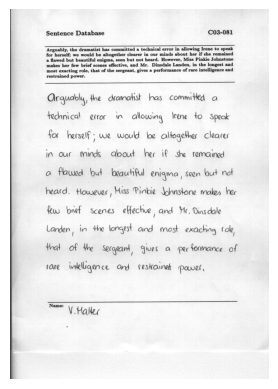

In [259]:
for images, labels in formdata_loader:
    images = images.to(device)
    plot_tensor(images[0].cpu().detach())
    break

In [262]:
image = images[0]
predicted_text = handwritting_to_text(image)

---
### Showing the predicted result
---


orguably the oeanatist has committed a
teonnica euor in ellowing tree too speak
for herssl wer would be altoghe cleore
po.n uor minds abool her if she reniieed pr.
a faaned bont beuati engina seen bont not
heard Houeer Miss Grinc buntere make her
ter loice scenes effeciie and Me. por lindde
Lander Me. in the longes and most exerting rale
shett iot the Seggent " gives sa parance wole
mare intinoue and retaan re puer



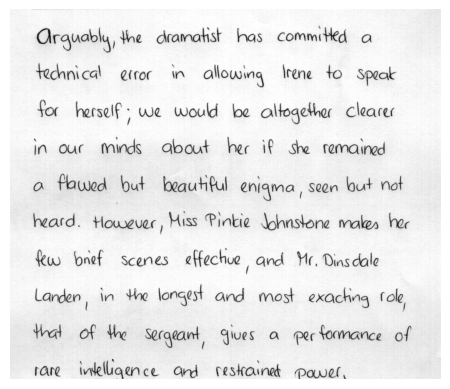

In [265]:
cropped_image = get_cropped_image(image, paragraph_segmentor)
plt.imshow(cropped_image.permute(1, 2, 0).cpu().detach(), cmap='gray')
plt.axis('off')
print(predicted_text)
plt.show()

In [251]:
from torchmetrics.text import CharErrorRate

total_cer = []
num_images = 0
actual = []
pred = []
for line, labels in dataloader:
    line = line[0]
    label = get_text_line(labels[0])
    words = generate_word_image_tensors(word_segmentation, line, THRESHOLD, WORD_KERNEL_DIMS)
    line_text = []
    for word in words:
        y_hat = word_recognizer(word.unsqueeze(0).to(device))
        predicted_text = ctc_greedy_decode_batch(y_hat.detach().cpu())[0]
        line_text.append(predicted_text)
    line_text = ' '.join(line_text)
    actual.append(label)
    pred.append(line_text)
    num_images += 1
    if num_images % 10 == 0:
        print(f'Done {num_images} images')
    if num_images == 1000:
        break

/tmp/ipykernel_34/212262076.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(label)


Done 10 images
Done 20 images
Done 30 images
Done 40 images
Done 50 images
Done 60 images
Done 70 images
Done 80 images
Done 90 images
Done 100 images
Done 110 images
Done 120 images
Done 130 images
Done 140 images
Done 150 images
Done 160 images
Done 170 images
Done 180 images
Done 190 images
Done 200 images
Done 210 images
Done 220 images
Done 230 images
Done 240 images
Done 250 images
Done 260 images
Done 270 images
Done 280 images
Done 290 images
Done 300 images
Done 310 images
Done 320 images
Done 330 images
Done 340 images
Done 350 images
Done 360 images
Done 370 images
Done 380 images
Done 390 images
Done 400 images
Done 410 images
Done 420 images
Done 430 images
Done 440 images
Done 450 images
Done 460 images
Done 470 images
Done 480 images
Done 490 images
Done 500 images
Done 510 images
Done 520 images
Done 530 images
Done 540 images
Done 550 images
Done 560 images
Done 570 images
Done 580 images
Done 590 images
Done 600 images
Done 610 images
Done 620 images
Done 630 images
D

In [255]:
cer = CharErrorRate()
print(f'CER on test data {cer(pred, actual) / 2}')

CER on test data 0.3449564278125763
